# 1. Introducció al problema que es vol resoldre: Que i com.

L'objectiu principal d'aquesta pràctica es trobar la millor parametrització d'una SVM a partir d'un conjunt de dades. 

Una SVM (o Support Vector Machine) és un algorisme d'aprenentatge automàtic utilitzat principalment en tasques de classificació i regressió.

En aquest cas utilitzarem la SVM per fer una classificació de imatges, he emprat el dataset de paisatges **a2.zip**.

El conjunt de dades representa paisatges o zones interiors de 15 classes diferents. Les imatges són reals i amb gaire pre tractament, això vol dir que haurem d'extreure característiques de les imatges per poder trobar els millors resultats possibles.

S'empraran les llibreries de `scikit` per fer els experiments seguint les bones pràctiques recomanades.

# 2. Tractament de dades

La primera passa serà importar les llibreries necessàries per al tractament d'imatges, anàlisi i entrenament de dades.

Llibreries utilitzades:

In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage.feature import hog
from skimage import data, exposure, feature, io, color
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score , confusion_matrix, classification_report
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
from skimage import io, color, transform
import time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

Abans de començar amb l'extracció de característiques o entrenament d'una SVM, mostram la primera imatge de cada categoria de les dades d'entrenament en una graella. Així, podem visualitzar i entendre millor les dades amb les quals esteim treballant.

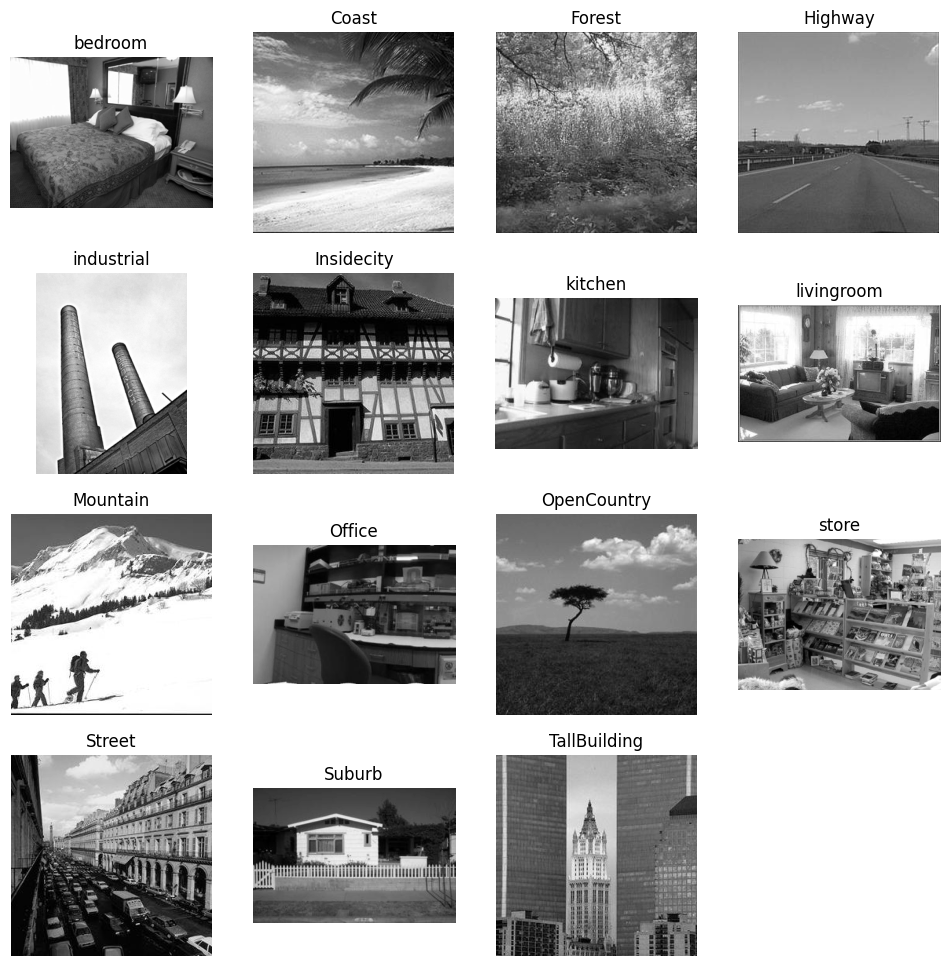

In [2]:
testa2 = 'a2/data/test'
traina2 = 'a2/data/train'

categorias = os.listdir(traina2)

num_categories = len(categorias)
rows = 4  # Número de filas en la cuadrícula
cols = num_categories // rows + 1  # Número de columnas en la cuadrícula

plt.figure(figsize=(12, 12))

for i, category in enumerate(categorias):
    category_path = os.path.join(traina2, category) # Ruta de la categoría
    image_files = os.listdir(category_path) # Lista de archivos en la categoría
    if image_files:
        first_image_path = os.path.join(category_path, image_files[0]) # Ruta de la primera imagen
        img = imread(first_image_path) # Lectura de la imagen

    plt.subplot(rows, cols, i + 1) 
    plt.imshow(img, cmap="gray") 
    plt.axis('off') 
    plt.title(category) 
 
plt.show()

# 3. Experiments realitzats: descripció de cada experiment i resultats obtinguts

Per a l'extracció de característiques he emprat el **HOG**, que significa "Histogram of Oriented Gradients", després aquestes característiques les podem passar a un `DataFrame` per poder operar amb dades i no amb les imatges directament. 



**HOG**, és una tècnica d'extracció de característiques.
El càlcul de característiques es considera una etapa de preprocessament d'imatges.
Aquestes característiques s'utilitzen posteriorment com a entrades per entrenar el model de classificació, el nostre SVM.

En aquest cas utilitzarem la funció `hog` de `skimage.feature`. A aquesta funció li podem passar diferents paràmetres que faran que el resultat del model pugui variar, hem de trobar els millors paràmetres possibles.

## Experiment sobre `image_size`
El primer paràmetre que haurem d'estudiar és la mida de la imatge `(image_size)`. Això vol dir que la imatge pot prendre diferents valors de mida, i aquests valors faran que la precisió del nostre SVM pugui millorar o no. 

Com a primer experiment, cream un objecte SVM bàsic on el que farem serà passar-li com a paràmetre diferents valors de `image_size` per veure si la precisió del model depèn d'aquesta variable en gran mida o no. La resta de paràmetres que li passam al HOG seran els mateixos, ja que, ara només ens interessa estudiar l'atribut `image_size`.

Parámetros: pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=8, image_size=(8, 8)
Precisión del modelo SVM: 0.16666666666666666

Parámetros: pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=8, image_size=(16, 16)
Precisión del modelo SVM: 0.26

Parámetros: pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=8, image_size=(32, 32)
Precisión del modelo SVM: 0.39666666666666667

Parámetros: pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=8, image_size=(64, 64)
Precisión del modelo SVM: 0.5

Parámetros: pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=8, image_size=(128, 128)
Precisión del modelo SVM: 0.5233333333333333

Parámetros: pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=8, image_size=(256, 256)
Precisión del modelo SVM: 0.5666666666666667



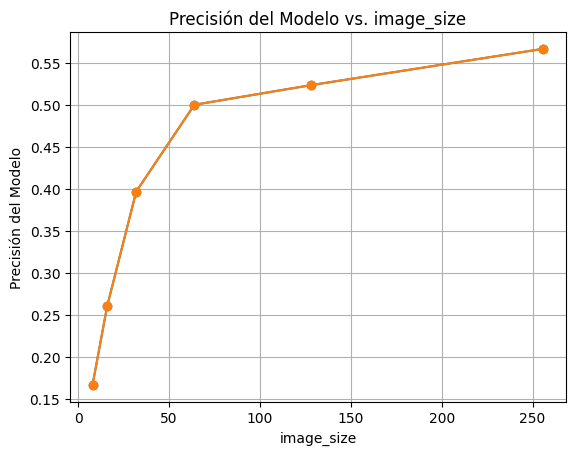

Mejor configuración de parámetros:
pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=8, image_size=(256, 256)
Mejor precisión: 0.5666666666666667


In [3]:
def calcular_hog_features(train_dir, categorias, pixels_per_cell, cells_per_block, orientations, image_size):
    features_list = []
    labels = []

    for i, category in enumerate(categorias):
        category_path = os.path.join(train_dir, category)
        image_files = os.listdir(category_path)

        for image_file in image_files:
            image_path = os.path.join(category_path, image_file)

            img = io.imread(image_path, as_gray=True)
            img = transform.resize(img, image_size)

            # Ajuste de contraste adaptativo
            img = exposure.equalize_adapthist(img)

            features = hog(img, orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)

            features_list.append(features)
            labels.append(category)

    df = pd.DataFrame(features_list)
    df['label'] = labels

    return df 

 # Definir las diferentes configuraciones de parámetros HOG a probar
parametros_a_probar = [
    ((4, 4), (2, 2), 8, (8, 8)),
    ((4, 4), (2, 2), 8, (16, 16)),
    ((4, 4), (2, 2), 8, (32, 32)),
    ((4, 4), (2, 2), 8, (64, 64)),
    ((4, 4), (2, 2), 8, (128, 128)),
    ((4, 4), (2, 2), 8, (256, 256)),
]

mejor_precision = 0.0
mejores_parametros = None
precisions = []
image_sizes = []

for params in parametros_a_probar:
    df = calcular_hog_features(traina2, categorias, *params)

    # Separar características y etiquetas
    X = df.drop('label', axis=1)
    y = df['label']

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear y entrenar el modelo SVM 
    svm_model = SVC(kernel='rbf') # Kernel RBF por defecto
    svm_model.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = svm_model.predict(X_test)

    # Calcular la precisión del modelo
    accuracy = accuracy_score(y_test, y_pred)

    precisions.append(accuracy)
    image_sizes.append(params[3]) 
    
    print(f"Parámetros: pixels_per_cell={params[0]}, cells_per_block={params[1]}, orientations={params[2]}, image_size={params[3]}")
    print("Precisión del modelo SVM:", accuracy)
    print()

    # Actualizar la mejor precisión y los mejores parámetros si es necesario
    if accuracy > mejor_precision:
        mejor_precision = accuracy
        mejores_parametros = params

plt.plot(image_sizes, precisions, marker='o')
plt.title('Precisión del Modelo vs. image_size')
plt.xlabel('image_size')
plt.ylabel('Precisión del Modelo')
plt.grid(True)
plt.show()

print("Mejor configuración de parámetros:")
print(f"pixels_per_cell={mejores_parametros[0]}, cells_per_block={mejores_parametros[1]}, orientations={mejores_parametros[2]}, image_size={mejores_parametros[3]}")
print("Mejor precisión:", mejor_precision)

Com hem pogut comprovar, la mida de la imatge `(image_size)` és un paràmetre a tenir en compte. Com s'ha vist en aquesta execució, depenent de la mida de la imatge, el resultat de la precisió del model canvia. Això vol dir que hem de seleccionar la mida de la imatge correctament degut a que influirà en la capacitat del model per realitzar prediccions precises.

El problema està en que no podem prendre una mida de imatge massa gran simplement pel fet que el processament de tants de píxels per imatge requereix molt de temps.

* Quan més petita és la mida de la imatge, la precisió del model disminueix.

* Quan més gran és la mida de la imatge, la precisió del model augmenta.

## Experiment sobre els paràmetres `orientations `,  `pixels_per_cell `,  `cells_per_block `
Després d'haver fet les proves amb la mida de les imatges, ens queda provar els altres paràmetres:
* orientations
* pixels_per_cell
* cells_per_block

Haurem de tenir en compte aquells paràmetres que donen una millor precisió, per poder fer proves amb ells.  


El segon experiment consisteix en provar diferents valors per aquests paràmetres i juntament amb els millors resultats del primer experiment, trobar la millor precisió del nostre model SVM.

_NOTA: `image_size = (64, 64)` dona bons resultats de precisió en un temps d'execució considerable, per tant es faran les següents proves amb aquest valor._

Parámetros: pixels_per_cell=(1, 1), cells_per_block=(1, 1), orientations=8, image_size=(64, 64)
Precisión del modelo SVM: 0.2866666666666667
Tiempo de ejecución: 525.23 segundos

Parámetros: pixels_per_cell=(2, 2), cells_per_block=(2, 2), orientations=10, image_size=(64, 64)
Precisión del modelo SVM: 0.43333333333333335
Tiempo de ejecución: 447.75 segundos

Parámetros: pixels_per_cell=(2, 2), cells_per_block=(2, 2), orientations=12, image_size=(64, 64)
Precisión del modelo SVM: 0.42333333333333334
Tiempo de ejecución: 464.67 segundos

Parámetros: pixels_per_cell=(4, 4), cells_per_block=(4, 4), orientations=8, image_size=(64, 64)
Precisión del modelo SVM: 0.5433333333333333
Tiempo de ejecución: 381.67 segundos

Parámetros: pixels_per_cell=(4, 4), cells_per_block=(4, 4), orientations=10, image_size=(64, 64)
Precisión del modelo SVM: 0.54
Tiempo de ejecución: 388.18 segundos

Parámetros: pixels_per_cell=(4, 4), cells_per_block=(4, 4), orientations=12, image_size=(64, 64)
Precisión del mod

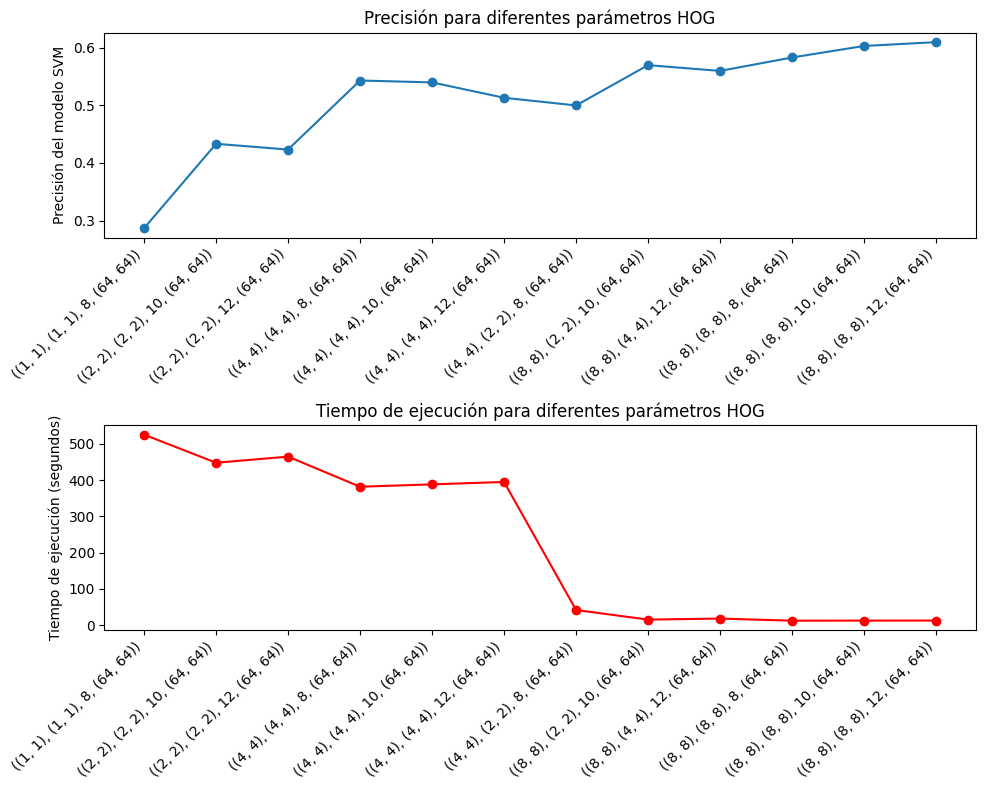

In [4]:
def calcular_hog_features(train_dir, categorias, pixels_per_cell, cells_per_block, orientations, image_size):
    features_list = []
    labels = []

    for i, category in enumerate(categorias):
        category_path = os.path.join(train_dir, category)
        image_files = os.listdir(category_path)

        for image_file in image_files:
            image_path = os.path.join(category_path, image_file)

            img = io.imread(image_path, as_gray=True)
            img = transform.resize(img, image_size)

            # Ajuste de contraste adaptativo
            img = exposure.equalize_adapthist(img)

            features = hog(img, orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)

            features_list.append(features)
            labels.append(category)

    df = pd.DataFrame(features_list)
    df['label'] = labels

    return df

# Definir los diferentes parámetros HOG a probar
parametros_a_probar = [
    ((1, 1), (1, 1), 8, (64, 64)),
    ((2, 2), (2, 2), 10, (64, 64)),
    ((2, 2), (2, 2), 12, (64, 64)),
    ((4, 4), (4, 4), 8, (64, 64)),
    ((4, 4), (4, 4), 10, (64, 64)),
    ((4, 4), (4, 4), 12, (64, 64)),
    ((4, 4), (2, 2), 8, (64, 64)),
    ((8, 8), (2, 2), 10, (64, 64)),
    ((8, 8), (4, 4), 12, (64, 64)),
    ((8, 8), (8, 8), 8, (64, 64)),
    ((8, 8), (8, 8), 10, (64, 64)),
    ((8, 8), (8, 8), 12, (64, 64)),
]

mejor_precision = 0.0
mejores_parametros = None

precisions = []
elapsed_times = []

for params in parametros_a_probar:
    start_time = time.time()
    df = calcular_hog_features(traina2, categorias, *params)

    # Separar características y etiquetas
    X = df.drop('label', axis=1)
    y = df['label']

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear y entrenar el modelo SVM 
    svm_model = SVC(kernel='rbf') # Kernel RBF por defecto
    svm_model.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = svm_model.predict(X_test)

    # Calcular la precisión del modelo
    accuracy = accuracy_score(y_test, y_pred)

    end_time = time.time()
    elapsed_time = end_time - start_time
    precisions.append(accuracy)
    elapsed_times.append(elapsed_time)
    print(f"Parámetros: pixels_per_cell={params[0]}, cells_per_block={params[1]}, orientations={params[2]}, image_size={params[3]}")
    print("Precisión del modelo SVM:", accuracy)
    print(f"Tiempo de ejecución: {elapsed_time:.2f} segundos")
    print()

    # Actualizar la mejor precisión y los mejores parámetros si es necesario
    if accuracy > mejor_precision:
        mejor_precision = accuracy
        mejores_parametros = params

print("Mejor configuración de parámetros:")
print(f"pixels_per_cell={mejores_parametros[0]}, cells_per_block={mejores_parametros[1]}, orientations={mejores_parametros[2]}, image_size={mejores_parametros[3]}")
print("Mejor precisión:", mejor_precision) 

# Crear gráficas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Gráfica de precisión
ax1.plot(range(len(parametros_a_probar)), precisions, marker='o')
ax1.set_xticks(range(len(parametros_a_probar)))
ax1.set_xticklabels([str(params) for params in parametros_a_probar], rotation=45, ha='right')
ax1.set_ylabel('Precisión del modelo SVM')
ax1.set_title('Precisión para diferentes parámetros HOG')

# Gráfica de tiempo de ejecución
ax2.plot(range(len(parametros_a_probar)), elapsed_times, marker='o', color='r')
ax2.set_xticks(range(len(parametros_a_probar)))
ax2.set_xticklabels([str(params) for params in parametros_a_probar], rotation=45, ha='right')
ax2.set_ylabel('Tiempo de ejecución (segundos)')
ax2.set_title('Tiempo de ejecución para diferentes parámetros HOG')

plt.tight_layout()
plt.show()

Per una millor visualització de les dades i el resultat de la precisió dels models, s'han creat unes gràfiques que mostren l'evolució d'aquests valors segons els paràmetres que li hem passat a la funció `hog`. 

Com hem pogut comprovar, la millor precisió es dona amb els paràmetres:
* `orientations = 12`
* `pixels_per_cell = (8, 8)`
* `cells_per_block = (8, 8)`
* `image_size = (64, 64)`

De la passa anterior hem obtingut aquells paràmetres que resulten en una millor precisió del model SVM en un temps d'execució considerable. 

Aquests són els paràmetres que hem de seleccionar per aplicar al nostre **HOG**. 

Ara aplicarem la cerca exhaustiva `GridSearchCV` juntament amb `KFold` per obtenir els millors hiperparàmetres.

Definim els paràmetres per ajustar la SVM en forma de diccionari `param_grid`. Aquest diccionari conté tots els valors a provar i amb l'atribut `best_estimator_` de l'objecte `GridSearchCV` extreurem els millors paràmetres per el nostre model.

In [5]:
features_list = []
labels = []
 
# Parámetros HOG
pixels_per_cell = (8, 8)
cells_per_block = (8, 8)
orientations = 12
img_size = (64, 64)
# Procesar cada categoría
for i, category in enumerate(categorias):
    category_path = os.path.join(traina2, category)  # Ruta de la categoría
    image_files = os.listdir(category_path)  # Lista de archivos en la categoría

    for image_file in image_files:
        image_path = os.path.join(category_path, image_file)  # Ruta de la imagen
        
        # Cargar la imagen en escala de grises y redimensionar si es necesario
        img = io.imread(image_path, as_gray=True)
        img = transform.resize(img, img_size)  # Redimensionar a un tamaño fijo si es necesario
        # Ajuste de contraste adaptativo
        img = exposure.equalize_adapthist(img)
        # Calcular las características HOG
        features = hog(img, orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
        
        features_list.append(features)
        labels.append(category)

# Crear un DataFrame de Pandas con las características y etiquetas
df = pd.DataFrame(features_list)
df['label'] = labels

# Visualizar las primeras filas del DataFrame
print(df.head())
percentage = df['label'].value_counts(normalize=True) * 100
print(percentage)

# Separar las características y etiquetas del DataFrame
X = df.drop('label', axis=1)  # Características
y = df['label']  # Etiquetas

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un modelo SVM
svm_model = SVC(kernel='rbf')

# Entrenar el modelo SVM
svm_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = svm_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo SVM:", accuracy)

# Definir la cuadrícula de parámetros
param_grid = {
    'C':[0.1,1,10,100],           # Valores para el parámetro de regularización
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],   # Tipos de kernel a probar
    'gamma': [0.0001,0.001,0.01,0.1,1, 'scale', 'auto'],    # Valores para el parámetro gamma (dependiendo del kernel)
}

# Crear un modelo SVM
svm_model = SVC()

# Crear un objeto KFold para la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=kf, verbose=2, n_jobs=-1)

# Realizar la búsqueda en cuadrícula en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener la mejor configuración de hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor modelo ajustado
best_svm_model = grid_search.best_estimator_

# Realizar predicciones con el mejor modelo en el conjunto de prueba
y_pred = best_svm_model.predict(X_test)

# Calcular la precisión del mejor modelo en el conjunto de prueba
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del mejor modelo SVM en el conjunto de prueba:", accuracy)


          0         1         2         3         4         5         6  \
0  0.020152  0.000000  0.000000  0.000000  0.001264  0.009330  0.081756   
1  0.105558  0.000000  0.003959  0.000726  0.004757  0.005819  0.005978   
2  0.014754  0.000958  0.006057  0.002692  0.000828  0.009329  0.049295   
3  0.019494  0.005353  0.010924  0.027571  0.012244  0.001097  0.013798   
4  0.017774  0.013405  0.006531  0.000898  0.014947  0.004592  0.013164   

          7         8         9  ...       759       760       761       762  \
0  0.047017  0.000000  0.000000  ...  0.001582  0.005440  0.001794  0.048736   
1  0.012346  0.002465  0.006707  ...  0.005182  0.013957  0.005912  0.034220   
2  0.024520  0.014194  0.011332  ...  0.010076  0.006578  0.017492  0.054202   
3  0.001839  0.001679  0.003886  ...  0.003132  0.012633  0.007295  0.017124   
4  0.000000  0.005146  0.003031  ...  0.002136  0.012022  0.003583  0.043371   

        763       764       765       766       767    label  
0  0.

Ara podem mostrar la matriu de confusió del nostre millor model SVM.

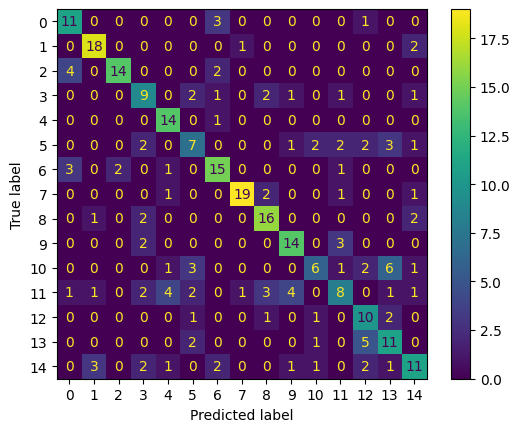

Precisión en el conjunto de prueba: 0.61
Informe de clasificación en el conjunto de prueba:
               precision    recall  f1-score   support

       Coast       0.58      0.73      0.65        15
      Forest       0.78      0.86      0.82        21
     Highway       0.88      0.70      0.78        20
  Insidecity       0.47      0.53      0.50        17
    Mountain       0.64      0.93      0.76        15
      Office       0.41      0.35      0.38        20
 OpenCountry       0.62      0.68      0.65        22
      Street       0.90      0.79      0.84        24
      Suburb       0.67      0.76      0.71        21
TallBuilding       0.67      0.74      0.70        19
     bedroom       0.55      0.30      0.39        20
  industrial       0.47      0.29      0.36        28
     kitchen       0.45      0.67      0.54        15
  livingroom       0.46      0.58      0.51        19
       store       0.55      0.46      0.50        24

    accuracy                           0.

In [6]:
# Entrena el modelo SVM
clf = SVC(random_state=0)
clf.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
predictions = clf.predict(X_test)

# Obtén las etiquetas únicas y asigna números a las etiquetas
unique_labels = clf.classes_
label_to_number = {label: i for i, label in enumerate(unique_labels)}
number_to_label = {i: label for i, label in enumerate(unique_labels)}
y_test_numbers = np.array([label_to_number[label] for label in y_test])
predictions_numbers = np.array([label_to_number[label] for label in predictions])

# Calcula la matriz de confusión
cm = confusion_matrix(y_test_numbers, predictions_numbers)
# Crea el gráfico de matriz de confusión con números en lugar de etiquetas
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.arange(len(unique_labels)))
disp.plot()
plt.show()


# Entrenar el modelo SVM (si aún no se ha hecho)
clf = SVC(random_state=0)
clf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
predictions = clf.predict(X_test)

# Calcular la precisión en el conjunto de prueba
accuracy = accuracy_score(y_test, predictions)
print("Precisión en el conjunto de prueba:", accuracy)

# Generar un informe de clasificación
classification_rep = classification_report(y_test, predictions)
print("Informe de clasificación en el conjunto de prueba:\n", classification_rep)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, predictions)


Com hem pogut comprovar amb el darrer experiment, la precisió del millor model és de un 61% amb els paràmetres seleccionats.

# 4. Anàlisi de resultats i conclusions

1. Impacte de la mida de la imatge:
   
   La variació de la mida de la imatge ha de ser considerada ja que la precisió del model depèn bastant d'aquesta mida.
   
   En el primer experiment veim que a mesura que afegim més píxels a la imatge, la precisió del model augmenta.

   S'observa una disminució en el temps d'execució amb les configuracions de mida d'imatge més petita, però a costa d'una baixa precisió. La millora de la mida d'imatge té un límit en la millora del rendiment i pot implicar costos computacionals addicionals.


2. Variació dels paràmetres HOG:

   S'han provat diferents valors per als paràmetres: orientations, cells_per_block i pixels_per_cell.
   
   La millor configuració per a l'extracció de característiques s'obté amb els paràmetres `orientations=12`, `pixels_per_cell=(8, 8)`, `cells_per_block=(8, 8)` i `image_size=(64, 64)`.

   Els paràmetres HOG tenen un impacte significatiu en la precisió del model. La combinació adequada d'aquests paràmetres és crucial per aconseguir un rendiment òptim.


3. Precisió del model:

   La millor precisió del model que s'ha obtingut és d'un 61%, que s'ha aconseguit amb la configuració de paràmetres i mida d'imatge especificats anteriorment.

   Malgrat només hem aconseguit una precisió del 61%, sempre és possible continuar optimitzant el model explorant altres mètodes d'extracció de característiques o utilitzant altres algoritmes de classificació.


